# Self Driving Car Engineer Project 4 - Advanced Lane Line Detection
**Benjamin Söllner, 20.06.2017**

---

<img src="project_carnd_4_finding_lane_lines_400.png" alt="Fun Project Header Image" style="margin: 0;"/>

---

<br />
<div id="toc"></div>

In [1]:
%%javascript
/* JavaScript plugin that generates a Table of Contents */
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

## Useful Packages, Configuration, and Helper Functions

In [2]:
### CELL 1 ###

# Import some useful packages
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob # to grab a set of files from a path with wildcards
import ntpath
import itertools
import pickle
import collections
%matplotlib inline

# settings and constants
TEST_IMAGES = glob.glob('test_images/*.jpg') # all test images
TEST_COLS = 3 # number of columns for displaying test images
CAL_PICKLE_FILE = "pickles/cal.p" # pickle file holding camera calibration data
CAL_TEST_IMAGE = "camera_cal/calibration1.jpg" # test image for calibration
THRESH_TEST_IMAGE = "test_images/test6.jpg" # test image for thresholding
THRESH_MAG = (10, 130) # sobel magnitude threshold
THRESH_DIR = (0.7, 1.5) # sobel directional threshold
THRESH_S = (15, 255) # s channel threshold
UNWARP_PLANE = [(570,460), (711,460), (1064,660), (226,660)] # plane on original image that should be unwarped
UNWARP_X_OFFSET = 280 # left/right margin after plane is unwarped
UNWARP_Y_OFFSET = 20 # top/bottom margin after plane is unwarped
UNWARP_TEST_IMAGE = "test_images/straight_lines1.jpg" # test image for unwarping
LANE_Y_M_PER_PIX = 30/720 # number of meters per pixel in y-direction
LANE_X_M_PER_PIX = 3.7/700 # number of meters per pixel in x-direction
SEARCH_R_DEV_THRESHOLD = 0.1 # percentage the curvature can deviate between right and left lane marking

# Function to run all test images through function and display them
def run_all_test_images(processing_function, output='image', cmap=None):
    global TEST_IMAGES
    # generate number of subplots
    figure, plots = plt.subplots(int(np.ceil(len(TEST_IMAGES)/TEST_COLS)), 3, figsize=(20,10))
    # go through all test images
    for i, image_name in enumerate(TEST_IMAGES):
        # load image, apply processing function and plot output 
        image = cv2.imread(image_name)
        o = processing_function(image)
        p = plots[int(i/TEST_COLS)][i%TEST_COLS]
        # output can be an image or a list of (xs, ys) tuples.
        if output == 'image':
            if cmap is None:
                p.imshow(o)
            else:
                p.imshow(o, cmap=cmap)
        elif output == 'multiscatter':
            for xys in o:
                p.scatter(xys[0], xys[1])
        # add title
        p.set_title(ntpath.basename(image_name), fontsize=30)


## Calibrating Camera

**Task #1:** Compute the camera matrix and distortion coefficients. Provide an example of a distortion corrected calibration image.

OpenCV functions or other methods were used to calculate the correct camera matrix and distortion coefficients using the calibration chessboard images provided in the repository. The distortion matrix should be used to un-distort one of the calibration images provided as a demonstration that the calibration is correct. Example of undistorted calibration image is Included in the writeup (or saved to a folder).

### Finding Chessboard Corners

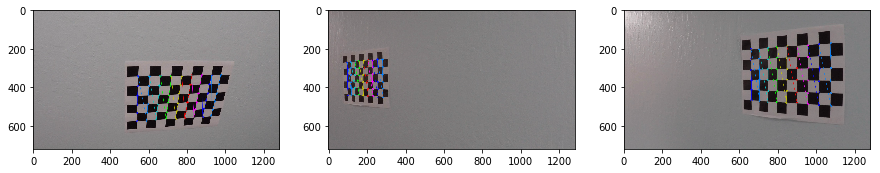

In [3]:
### CELL 2 ###

# number of rows and cols on the checkerboard
cal_rows = 6
cal_cols = 9

# prepare object points (3-dimensional), like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
cal_refpoints = np.zeros((cal_rows*cal_cols,3), np.float32)
cal_refpoints[:,:2] = np.mgrid[0:cal_rows, 0:cal_cols].T.reshape(-1,2)

# all object and image points
cal_objpoints = [] # 3d points in real world space
cal_imgpoints = [] # 2d points in image plane.

# list of calibration images
cal_images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
cal_no_checkboard_images = 3
cal_checkboard_images = []
# walk through the calibration images
for index, file in enumerate(cal_images):
    image = cv2.imread(file)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Find the chessboard corners
    returncode, corners = cv2.findChessboardCorners(gray, (cal_rows,cal_cols), None)
    # If found, add object and found image points
    if returncode == True:
        cal_objpoints.append(cal_refpoints)
        cal_imgpoints.append(corners)
        # Draw and display the corners
        cv2.drawChessboardCorners(image, (cal_rows, cal_cols), corners, returncode)
        output_name = 'debug_images/corners_found_'+ntpath.basename(file)
        cv2.imwrite(output_name, image)
        if len(cal_checkboard_images) < cal_no_checkboard_images:
            cal_checkboard_images.append(image)
        
# Visualize undistortion
figure, plots = plt.subplots(1, cal_no_checkboard_images, figsize=(15,10))
for plot, image in itertools.zip_longest(plots, cal_checkboard_images, fillvalue=None):
    if image is not None:
        plot.imshow(image)


### Calculating & Storing Distortion Parameters

In [4]:
### CELL 3 ###

# Test undistortion on an image
cal_test_image = cv2.imread(CAL_TEST_IMAGE)
cal_test_image_size = (cal_test_image.shape[1], cal_test_image.shape[0])

# Do camera calibration given object points and image points
cal_ret, cal_matrix, cal_dist, cal_rvecs, cal_tvecs = \
    cv2.calibrateCamera(cal_objpoints, cal_imgpoints, cal_test_image_size, None, None)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
CAL_PICKLE = {"matrix": cal_matrix, "dist": cal_dist}
pickle.dump( CAL_PICKLE, open( CAL_PICKLE_FILE, "wb" ) )

### Undistortion

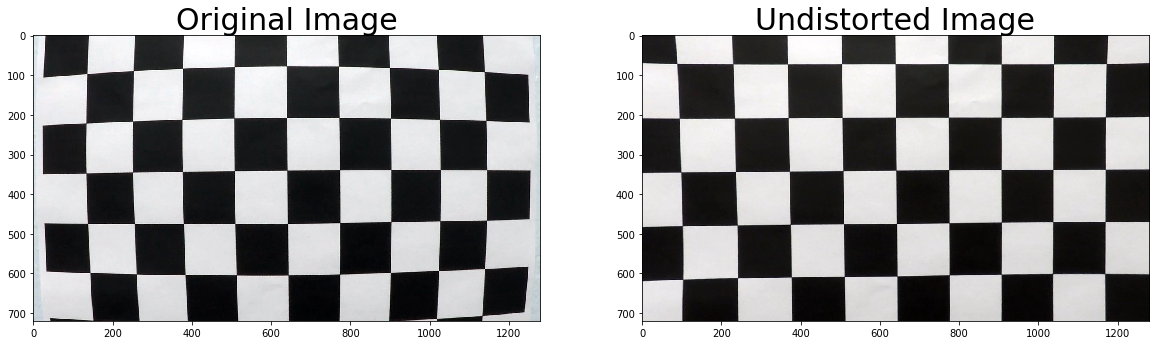

In [5]:
### CELL 4 ###

# restore the calibration pickle
CAL_PICKLE = pickle.load(open( CAL_PICKLE_FILE, "rb" ))

# image to do undistortion on an image using the calibration pickle
def undistort(image):
    global CAL_PICKLE
    # load image
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # undistort image
    return cv2.undistort(image, CAL_PICKLE["matrix"], CAL_PICKLE["dist"], None, CAL_PICKLE["matrix"])

# Test and visualize undistortion
cal_test_image = cv2.imread(CAL_TEST_IMAGE)
cal_test_undistort = undistort(cal_test_image)
cv2.imwrite('debug_images/test_undistort.jpg',cal_test_undistort)

# Visualize undistortion
figure, (plot1, plot2) = plt.subplots(1, 2, figsize=(20,10))
plot1.imshow(cal_test_image)
plot1.set_title('Original Image', fontsize=30)
plot2.imshow(cal_test_undistort)
plot2.set_title('Undistorted Image', fontsize=30)

## Distortion Correction

**Task #2:** Provide an example of a distortion-corrected image.

Distortion correction that was calculated via camera calibration has been correctly applied to each image. An example of a distortion corrected image should be included in the writeup (or saved to a folder) and submitted with the project.



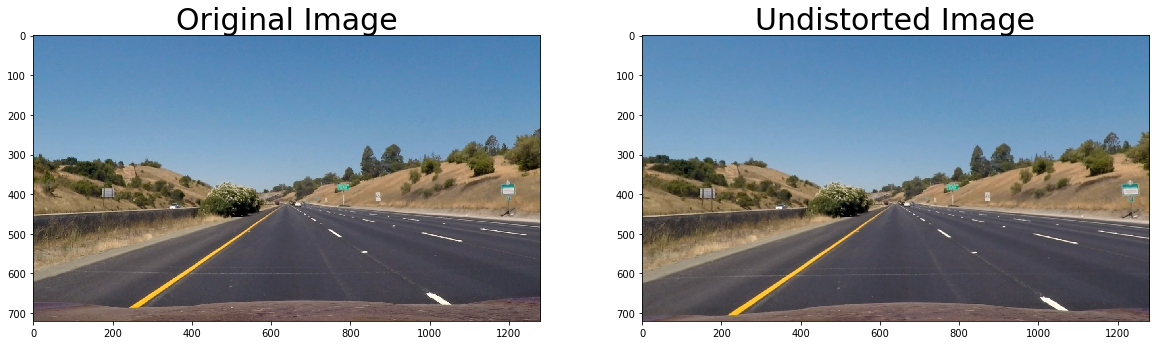

In [6]:
### CELL 5 ###

# Show undistortion on a 'real' image
figure, plots = plt.subplots(1, 2, figsize=(20,10))
unwarp_test_image = cv2.imread(UNWARP_TEST_IMAGE)
plots[0].imshow(cv2.cvtColor(unwarp_test_image, cv2.COLOR_BGR2RGB))
plots[0].set_title('Original Image', fontsize=30)
plots[1].imshow(undistort(unwarp_test_image))
plots[1].set_title('Undistorted Image', fontsize=30)


## Unwarping / Perspective Transform

**Task #3:** Perform a perspective transform and provide an example of a transformed image.

OpenCV function or other method has been used to correctly rectify each image to a "birds-eye view". Transformed images should be included in the writeup (or saved to a folder) and submitted with the project

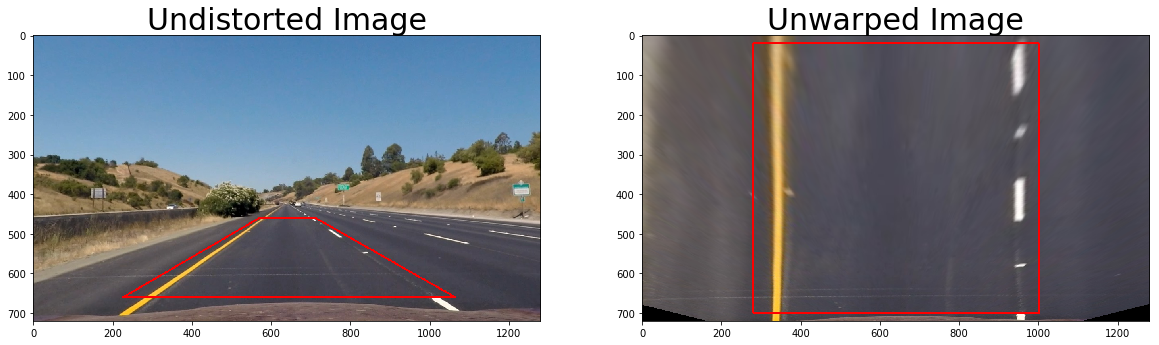

In [7]:
### CELL 6 ###

def show_lane_plane(image):
    global UNWARP_PLANE
    undistorted = undistort(image)
    color = [255,0,0]
    for (start, end) in zip([0,1,2,3], [1,2,3,0]):
        cv2.line(undistorted, UNWARP_PLANE[start], UNWARP_PLANE[end], [255,0,0], 3)
    return undistorted
    
def unwarp(image, show_plane=False):
    global UNWARP_PLANE
    global UNWARP_X_OFFSET
    global UNWARP_Y_OFFSET
    undistorted = undistort(image)
    source = UNWARP_PLANE
    x_offset = UNWARP_X_OFFSET 
    y_offset = UNWARP_Y_OFFSET 
    dim = (gray.shape[1], gray.shape[0])
    dest = [(x_offset, y_offset), (dim[0]-x_offset, y_offset), 
            (dim[0]-x_offset, dim[1]-y_offset), (x_offset, dim[1]-y_offset)]
    transform_matrix = cv2.getPerspectiveTransform(np.float32(source), np.float32(dest))
    inverse_matrix = cv2.getPerspectiveTransform(np.float32(dest), np.float32(source))
    unwarped = cv2.warpPerspective(undistorted, transform_matrix, dim, flags=cv2.INTER_LINEAR)
    if show_plane:
        for (start, end) in zip([0,1,2,3], [1,2,3,0]):
            cv2.line(unwarped, dest[start], dest[end], [255,0,0], 3)
    return unwarped, inverse_matrix

# Test and Visualize Unwarping
figure, plots = plt.subplots(1, 2, figsize=(20,10))
unwarp_test_image = cv2.imread(UNWARP_TEST_IMAGE)
unwarped_image, UNWARP_INV_MATRIX = unwarp(unwarp_test_image, show_plane=True)
plots[0].imshow(show_lane_plane(unwarp_test_image))
plots[0].set_title('Undistorted Image', fontsize=30)
plots[1].imshow(unwarped_image)
plots[1].set_title('Unwarped Image', fontsize=30)


## Identifying Lane Line Pixels

**Task #4:** Use color transforms, gradients or other methods to create a thresholded binary image. Provide an example of a binary image result.

A method or combination of methods (i.e., color transforms, gradients) has been used to create a binary image containing likely lane pixels. There is no "ground truth" here, just visual verification that the pixels identified as part of the lane lines are, in fact, part of the lines. Example binary images should be included in the writeup (or saved to a folder) and submitted with the project.



### Color & Gradient Threshold

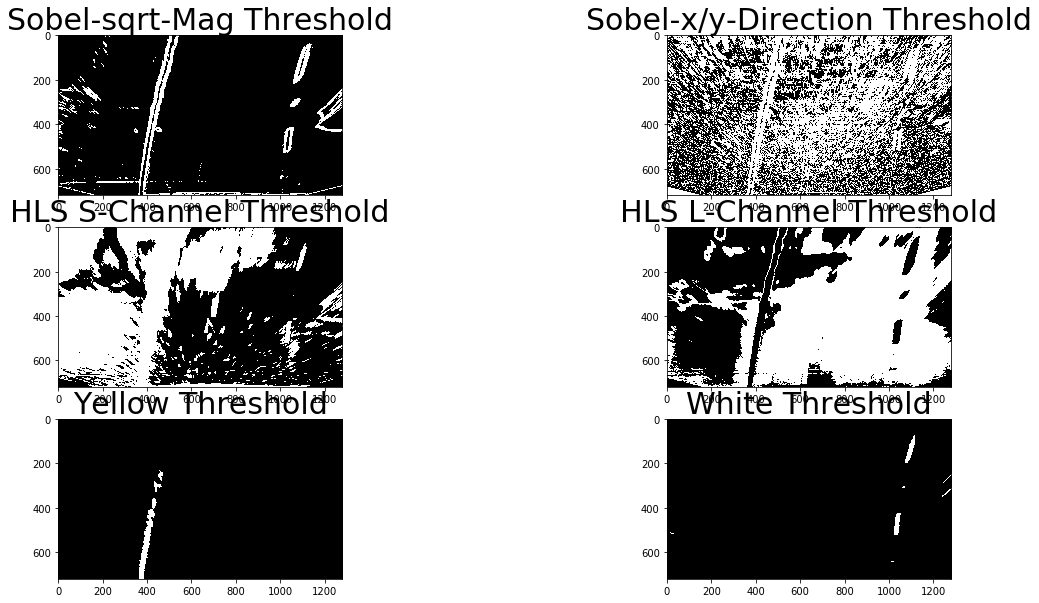

In [8]:
### CELL 7 ###

# applies Sobel x and y, then computes the magnitude of the gradient and applies a threshold
# DEPRECATED / not used
def mag_threshold(image, sobel_kernel=5, mag_thresh=(0, 255), doUnwarp=True):
    # unwarp if not already done (doUnwarp == False)
    if doUnwarp:
        image = unwarp(image)[0]
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Take the gradient in x and y separately
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the magnitude 
    grad_mag = np.sqrt(sobel_x**2 + sobel_y**2)
    # Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scale_factor = np.max(grad_mag)/255 
    grad_mag = (grad_mag/scale_factor).astype(np.uint8) 
    # Create a binary mask where mag thresholds are met
    mask = np.zeros_like(grad_mag)
    mask[(grad_mag >= mag_thresh[0]) & (grad_mag <= mag_thresh[1])] = 1
    # Return this mask as your binary_output image
    return mask

# applies Sobel x and y, then computes the direction of the gradient and applies a threshold.
# DEPRECATED / not used
def dir_threshold(image, sobel_kernel=5, thresh=(0, np.pi/2), doUnwarp=True):
    # unwarp if not already done (doUnwarp == False)
    if doUnwarp:
        image = unwarp(image)[0]
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Take the gradient in x and y separately
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the x and y gradients
    # Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    direction = np.arctan2(np.absolute(sobel_y), np.absolute(sobel_x))
    # Create a binary mask where direction thresholds are met
    mask =  np.zeros_like(direction)
    mask[(direction < thresh[0]) | (direction > thresh[1])] = 1
    # Return this mask as your binary_output image
    return mask

# thresholds the S-channel of HLS; use exclusive lower bound (>) and inclusive upper (<=)
# DEPRECATED / not used
def s_threshold(image, thresh=(0, 255), doUnwarp=True):
    # unwarp if not already done (doUnwarp == False)
    if doUnwarp:
        image = unwarp(image)[0]
    # Convert to HLS color space
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    # Apply a threshold to the S channel
    s = hls[:,:,2]
    mask = np.zeros_like(s)
    mask[(s >= thresh[0]) & (s <= thresh[1])] = 1
    # Return a binary image of threshold result
    return mask

# finds pixels with luminosity of road.
def l_threshold(image, thresh=(0, 255), doUnwarp=True):
    # unwarp if not already done (doUnwarp == False)
    if doUnwarp:
        image = unwarp(image)[0]
    # Convert to HLS color space
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    # Apply a threshold to the S channel
    l = hls[:,:,1]
    mask = np.zeros_like(l)
    mask[(l >= thresh[0]) & (l <= thresh[1])] = 1
    # Return a binary image of threshold result
    return mask

# finds pixels that are yellow (lane markers)
def yellow_threshold(image, doUnwarp=True):
    # unwarp if not already done (doUnwarp == False)
    if doUnwarp:
        image = unwarp(image)[0]
    # yellow range is defined by certain hsv-range
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    yellow = cv2.inRange(hsv, (20, 100, 100), (50, 255, 255))
    yellow_mask = np.float_(np.zeros_like(yellow))
    yellow_mask[yellow>0] = 1.0
    return yellow_mask

# finds pixels that are white (lane markers)
def white_threshold(image, doUnwarp=True):
    # unwarp if not already done (doUnwarp == False)
    if doUnwarp:
        image = unwarp(image)[0]
    # white color mask can be found either via hsv, hsl or rgb color space
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    hsl = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    white_sensitivity_1 = 68
    white_sensitivity_2 = 60
    white_1 = cv2.inRange(hsv, (0,0,255-white_sensitivity_1), (255,20,255))
    white_2 = cv2.inRange(hsl, (0,255-white_sensitivity_2,0), (255,255,white_sensitivity_2))
    white_3 = cv2.inRange(image, (200,200,200), (255,255,255))
    # we are okay with any sort of white
    white = white_1|white_2|white_3
    white_mask = np.float_(np.zeros_like(white))
    white_mask[white>0] = 1.0
    return white_mask

# Test and Visualize Different thresholds
thresh_test_image = cv2.imread(THRESH_TEST_IMAGE)
figure, plots = plt.subplots(3, 2, figsize=(20,10))
plots[0,0].imshow(mag_threshold(thresh_test_image, mag_thresh=THRESH_MAG), cmap='gray')
plots[0,0].set_title('Sobel-sqrt-Mag Threshold', fontsize=30)
plots[0,1].imshow(dir_threshold(thresh_test_image, thresh=THRESH_DIR), cmap='gray')
plots[0,1].set_title('Sobel-x/y-Direction Threshold', fontsize=30)
plots[1,0].imshow(s_threshold(thresh_test_image, thresh=THRESH_S), cmap='gray')
plots[1,0].set_title('HLS S-Channel Threshold', fontsize=30)
plots[1,1].imshow(l_threshold(thresh_test_image, thresh=(70,90)), cmap='gray')
plots[1,1].set_title('HLS L-Channel Threshold', fontsize=30)
plots[2,0].imshow(yellow_threshold(thresh_test_image), cmap='gray')
plots[2,0].set_title('Yellow Threshold', fontsize=30)
plots[2,1].imshow(white_threshold(thresh_test_image), cmap='gray')
plots[2,1].set_title('White Threshold', fontsize=30)


### Combining Filters

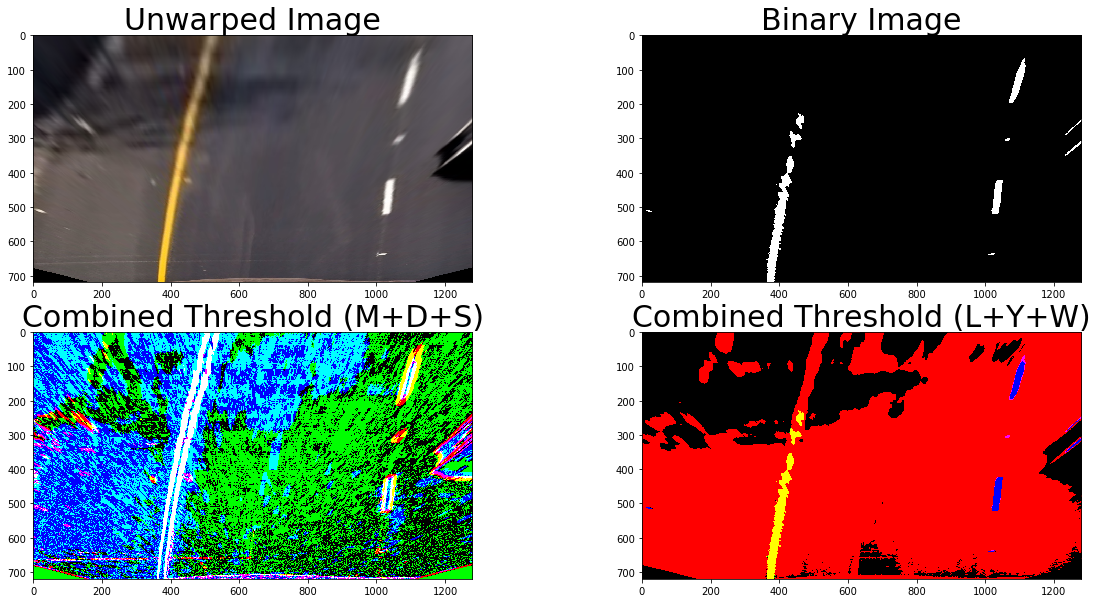

In [9]:
### CELL 8 ###

# returns a 6-channel image with all the thresholds
# (magintude & directional sobel, l-threshold, s-threshold, yellow & white mask)
def combined_threshold(image):
    global THRESH_MAG
    global THRESH_DIR
    global THRESH_S
    # unwarp upfront (taking care of that here instead of in the threshold 
    # functions lets us save some compute time)
    unwarped = unwarp(image)[0]
    # get all the thresholds
    m = mag_threshold(unwarped, mag_thresh=THRESH_MAG, doUnwarp=False)
    d = dir_threshold(unwarped, thresh=THRESH_DIR, doUnwarp=False)
    s = s_threshold(unwarped, thresh=THRESH_S, doUnwarp=False)
    l = l_threshold(unwarped, thresh=(70,200), doUnwarp=False)
    y = yellow_threshold(unwarped, doUnwarp=False)
    w = white_threshold(unwarped, doUnwarp=False)
    # stack them into 6-channel image
    color_binary = np.dstack((m, d, s, l, y, w))
    return color_binary

# uses all the thresholds to return a binary image of lane line pixels
def find_lane_line_pixels(image):
    # return all the thresholds
    combined = combined_threshold(image)
    m = combined[:,:,0].astype(int)
    d = combined[:,:,1].astype(int)
    s = combined[:,:,2].astype(int)
    l = combined[:,:,3].astype(int)
    y = combined[:,:,4].astype(int)
    w = combined[:,:,5].astype(int)
    # the most robust is to just extract the lane line pixels
    binary = (y|w) # also tried: ((y*2+w*2+l+(m&s)+(m&d))>=3)
    return binary.astype(float)

# Test and Visualize Combined thresholds
thresh_test_image = cv2.imread(THRESH_TEST_IMAGE)
figure, plots = plt.subplots(2, 2, figsize=(20,10))
plots[0,0].imshow(unwarp(thresh_test_image)[0])
plots[0,0].set_title('Unwarped Image', fontsize=30)
plots[0,1].imshow(find_lane_line_pixels(thresh_test_image), cmap='gray')
plots[0,1].set_title('Binary Image', fontsize=30)
plots[1,0].imshow(combined_threshold(thresh_test_image)[:,:,0:3])
plots[1,0].set_title('Combined Threshold (M+D+S)', fontsize=30)
plots[1,1].imshow(combined_threshold(thresh_test_image)[:,:,3:6])
plots[1,1].set_title('Combined Threshold (L+Y+W)', fontsize=30)

## Finding Lane Lines & Fitting Polynomial

**Task #5:** Identify lane-line pixels and fit their positions with a polynomial?

Methods have been used to identify lane line pixels in the rectified binary image. The left and right line have been identified and fit with a curved functional form (e.g., spine or polynomial). Example images with line pixels identified and a fit overplotted should be included in the writeup (or saved to a folder) and submitted with the project.

### Finding Lane Line Base

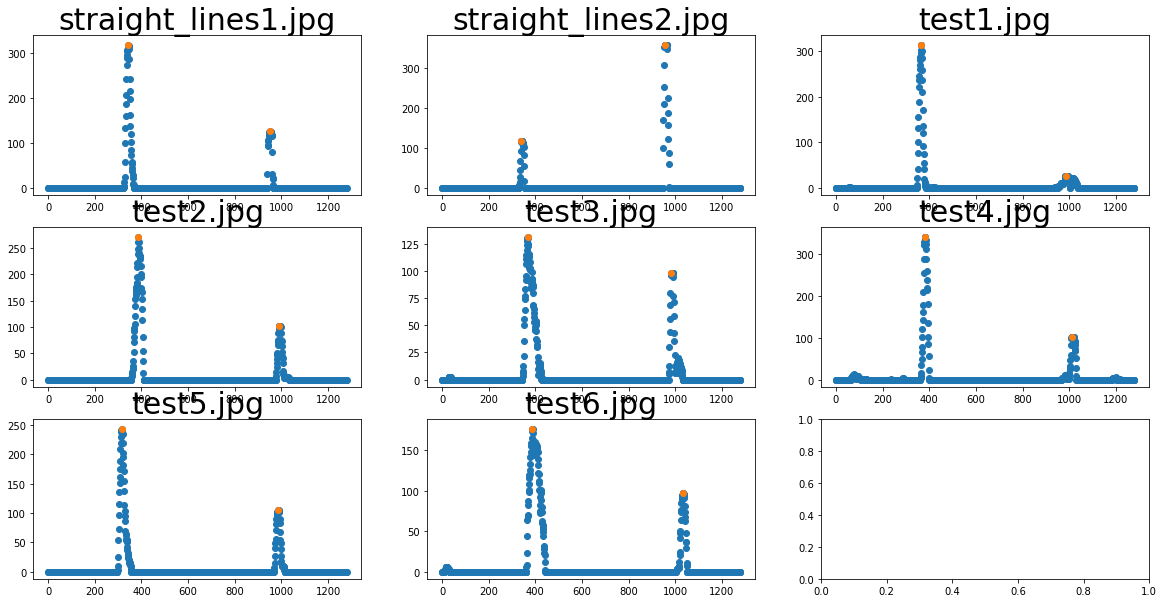

In [10]:
### CELL 9 ###

# return the histogram of the summed up whiteness across the y-axis of the lower half of the image
def whiteness_half_across_y(image):
    return np.sum(image[image.shape[0]//2:,:], axis=0)

# find the peaks of the left and right half of a sequence
def find_peaks(sequence):
    centerx = np.int(sequence.shape[0]/2)
    leftx_max = np.argmax(sequence[:centerx])
    rightx_max = np.argmax(sequence[centerx:]) + centerx
    return leftx_max, rightx_max

# find the lowermost starting point to trace lane line pixels of an image 
def find_base(lane_line_pixels):
    # find the left and right x-pixel
    sequence = whiteness_half_across_y(lane_line_pixels)
    leftx_max, rightx_max = find_peaks(sequence)
    # prepare output: return the sequence and the peaks as (xs, ys) tuples
    histogram_xs_ys = (range(0, len(sequence)), sequence)
    max_xs_ys = ([leftx_max, rightx_max], [sequence[leftx_max], sequence[rightx_max]])
    return [histogram_xs_ys, max_xs_ys]

# visualize lowest y-value to start tracing lane lines
def find_base_test(image):
    lane_line_pixels = find_lane_line_pixels(image)
    return find_base(lane_line_pixels)

run_all_test_images(find_base_test, output='multiscatter')


### ```Lane``` + ```LaneLine``` Class

In [11]:
### CELL 10 ###

# Class representing a lane line as collection of points on an image
class LaneLine:
    def __init__(self, xs, ys):
        self.xs = xs
        self.ys = ys
        self.fit = None
        self.err = None
        self.fit_poly()
    
    # Fit a polygon through the (y,x) points
    def fit_poly(self):
        # Fit a second order polynomial to each
        poly = np.polyfit(self.ys, self.xs, 2, full=True)
        self.fit, self.err = poly[0], poly[1]
        
    # Sample the fitted polygon across a number of y points
    def sample_poly(self, ys, yoffset=0):
        return self.fit[0]*ys**2 + self.fit[1]*ys + self.fit[2] + yoffset
    
    # Calculate the curvature of the polygon
    def curvature(self, y):
        global LANE_Y_M_PER_PIX
        global LANE_X_M_PER_PIX
        # re-fit the polygon in world-space
        fit = np.polyfit(self.ys*LANE_Y_M_PER_PIX, self.xs*LANE_X_M_PER_PIX, 2)
        return ((1 + (2*fit[0]*y*LANE_Y_M_PER_PIX + fit[1])**2)**1.5) / np.absolute(2*fit[0])
    
    # adding lanes will shift them to the left-right (used to average lanes)
    def __add__(self, other):
        self_dict = dict(zip(self.xs, self.ys))
        ys = []
        for other_x, other_y in zip(other.xs, other.ys):
            if other_x in self_dict:
                self_y = self_dict[other_x]
                ys.append(int(other_y + self_y))
            else:
                ys.append(other_y)
        return LaneLine(other.xs, np.array(ys))
    
    # dividing lanes by a scalar will move them across y-dimension (used to average lanes)
    def __truediv__(self, other):
        return LaneLine(self.xs, np.array([int(y/other) for y in self.ys]))
    
    # multiplying lanes by a scalar will move them across y-dimension (used to average lanes)
    def __mul__(self, other):
        return LaneLine(self.xs, np.array([int(y*other) for y in self.ys]))

In [12]:
### CELL 11 ###

# Class representing a Lane as a right + left lane line
class Lane:
    def __init__(self, left_line, right_line):
        self.left = left_line
        self.right = right_line
    
    # Curvature of a lane is defined as average curvature of the left + right lane line
    def curvature(self, y):
        l = self.left.curvature(y)
        r = self.right.curvature(y)
        return (l+r)/2
    
    # "Insanity" of a lane is high in case the lane width varies a lot
    def insanity(self, ys):
        ds = []
        # iterate across y-values and collect all lane widths
        for y in ys:
            l = self.left.fit[0]*ys**2 + self.left.fit[1]*ys + self.left.fit[2]
            r = self.right.fit[0]*ys**2 + self.right.fit[1]*ys + self.right.fit[2]
            ds.append(r-l)
        # get standard deviation of lane widths
        return np.std(ds)
    
    # Calculate offset from center by looking at x_vehicle_center in respect to left and right lane position
    def offset_from_center(self, y, x_vehicle_center):
        global LANE_X_M_PER_PIX
        x_l = self.left.sample_poly(y)
        x_r = self.right.sample_poly(y)
        x_lane_center = (x_r-x_l)/2
        return (x_lane_center-x_vehicle_center)*LANE_X_M_PER_PIX
    
    # adding lanes is defined as adding left and right lane lines (used to average lanes)
    def __add__(self, other):
        return Lane(self.left+other.left, self.right+other.right)
    
    # dividing lanes by scalar is defined as dividing lane lines (used to average lanes)
    def __truediv__(self, other):
        return Lane(self.left/other, self.right/other)
    
    # multiplying lanes by scalar is defined as multiplying lane lines (used to average lanes)
    def __mul__(self, other):
        return Lane(self.left*other, self.right*other)

### Sliding Window Search

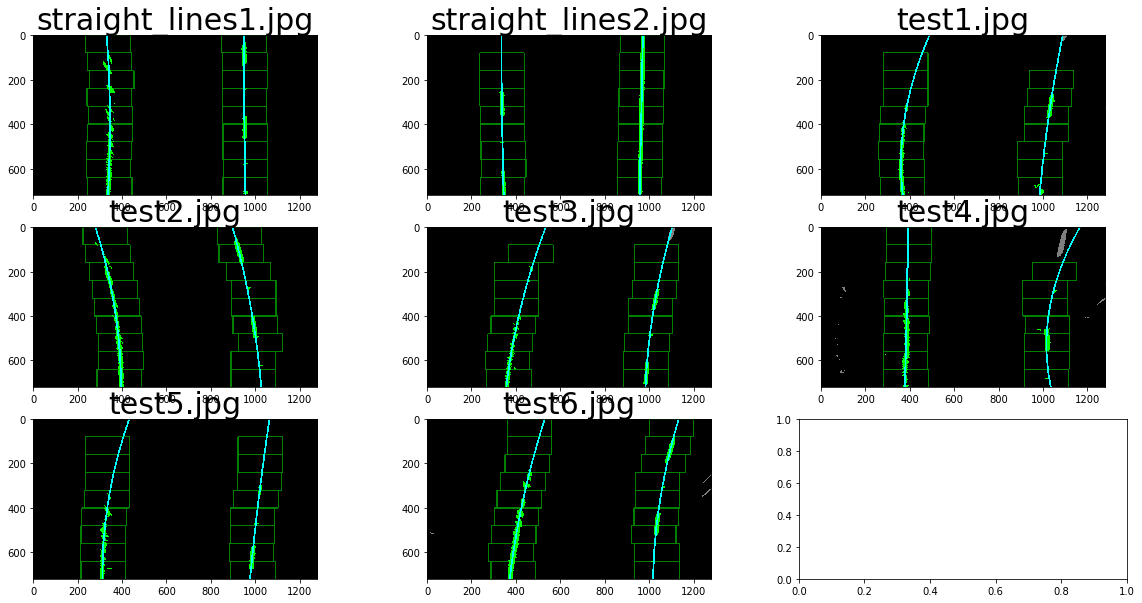

In [13]:
### CELL 12 ###

# nwindows = number of sliding windows
# wmargin = Set the width of the windows +/- margin
# minpix = minimum number of pixels found to recenter window
# giveupafter = give up lane tracing after not finding minpix number of pixels for a number of sliding windows
def slidewindow_search(image, nwindows=9, wmargin=100, minpix=50, giveupafter=3):
    # preprocess image and find base line pixels
    lane_line_img = find_lane_line_pixels(image)
    _, max_xs_ys = find_base(lane_line_img)
    leftx_base  = max_xs_ys[0][0]
    rightx_base = max_xs_ys[0][1]
    wheight = np.int(lane_line_img.shape[0]/nwindows)
    # Output image
    out_img = np.dstack((lane_line_img*.5, lane_line_img*.5, lane_line_img*.5))
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = lane_line_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_now = leftx_base
    rightx_now = rightx_base
    # Create empty lists to receive left and right lane pixel indices
    left_idxs = []
    right_idxs = []
    # Keep a counter to cancel tracing the lane if we didn't find minpix number of lane 
    # line pixels after a certain (giveupafter) number of trials
    giveup_left = 0
    giveup_right = 0
    # Step through sliding windows
    for w in range(nwindows):
        # Identify sliding windows
        w_y_lo = lane_line_img.shape[0] - (w+1)*wheight
        w_y_hi = lane_line_img.shape[0] - w*wheight
        # Left lane - only look if we didn't give up yet
        if giveup_left < giveupafter:
            # define x-range of sliding window
            w_xleft_lo = leftx_now - wmargin
            w_xleft_hi = leftx_now + wmargin
            # add all the lane line pixels in sliding window
            w_left_idxs = ((nonzeroy >= w_y_lo) & (nonzeroy < w_y_hi) & (nonzerox >= w_xleft_lo) & (nonzerox < w_xleft_hi)).nonzero()[0]
            left_idxs.extend(w_left_idxs)
            # add visualization for debugging
            cv2.rectangle(out_img,(w_xleft_lo,w_y_lo),(w_xleft_hi,w_y_hi),(0.,0.5,0.), 4) 
            if len(w_left_idxs) > minpix:
                # update sliding window center 
                leftx_now = np.int(np.mean(nonzerox[w_left_idxs]))
            else:
                # or update counter of unsuccessful sliding windows
                giveup_left += 1
        # Right lane - only look if we didn't give up yet
        if giveup_right < giveupafter:
            # define x-range of sliding window
            w_xright_lo = rightx_now - wmargin
            w_xright_hi = rightx_now + wmargin
            # add all the lane line pixels in sliding window
            w_right_idxs = ((nonzeroy >= w_y_lo) & (nonzeroy < w_y_hi) & (nonzerox >= w_xright_lo) & (nonzerox < w_xright_hi)).nonzero()[0]
            right_idxs.extend(w_right_idxs)
            # add visualization for debugging
            cv2.rectangle(out_img,(w_xright_lo,w_y_lo),(w_xright_hi,w_y_hi),(0.,0.5,0.), 4) 
            if len(w_right_idxs) > minpix:        
                # update sliding window center 
                rightx_now = np.int(np.mean(nonzerox[w_right_idxs]))
            else:
                # or update counter of unsuccessful sliding windows
                giveup_right += 1
    # Extract left and right line pixel positions
    left_xs = nonzerox[left_idxs]
    left_ys = nonzeroy[left_idxs]
    right_xs = nonzerox[right_idxs]
    right_ys = nonzeroy[right_idxs] 
    # Visualize for the purpose of debugging
    out_img[nonzeroy[left_idxs], nonzerox[left_idxs]] = [0., 1., 0.]
    out_img[nonzeroy[right_idxs], nonzerox[right_idxs]] = [0., 1., 0.]
    # Get Lane Lines
    if len(left_xs)==0 or len(right_xs)==0:
        # Nothing was found now :(
        return None, out_img
    else:
        # Otherwise: create LaneLine objects 
        left_line = LaneLine(left_xs, left_ys)
        right_line = LaneLine(right_xs, right_ys)
        # Visualize for the purpose of debugging
        fit_ys = np.linspace(0, lane_line_img.shape[0]-1, lane_line_img.shape[0] )
        left_fit_xs = left_line.sample_poly(fit_ys)
        right_fit_xs = right_line.sample_poly(fit_ys)
        for y, left_x, right_x in zip(fit_ys, left_fit_xs, right_fit_xs):
            out_img[int(y), int(left_x-4):int(left_x+4)] = [0., 1., 1.]
            out_img[int(y), int(right_x-4):int(right_x+4)] = [0., 1., 1.]
        return Lane(left_line, right_line), out_img
    
# Testing function (returning the debugging image and discarding the Lane objects)
def slidewindow_and_plot(image):
    _, out_img = slidewindow_search(image)
    return out_img
    
run_all_test_images(slidewindow_and_plot)


### Proximity Search

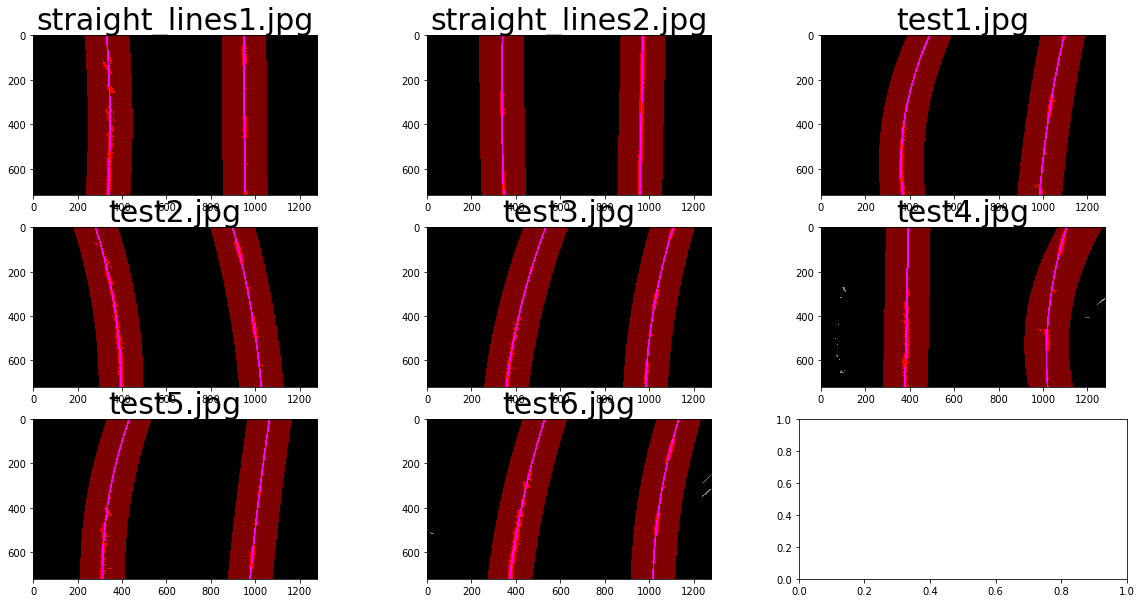

In [14]:
### CELL 13 ###

# Search in proximity of pmargin pixels around old_lane for lane lines in an image
def proximity_search(old_lane, image, pmargin=100):
    # Find lane line pixels (binary image)
    lane_line_img = find_lane_line_pixels(image)
    # Get nonzero pixels
    nonzero = lane_line_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Extract the pixels that are in pmargin distance around old lanes
    left_idxs = ((nonzerox > old_lane.left.sample_poly(nonzeroy, yoffset=-pmargin)) & \
                (nonzerox < old_lane.left.sample_poly(nonzeroy, yoffset=+pmargin)))
    right_idxs = ((nonzerox > old_lane.right.sample_poly(nonzeroy, yoffset=-pmargin)) & \
                 (nonzerox < old_lane.right.sample_poly(nonzeroy, yoffset=+pmargin)))
    # Get left and right x and y values
    left_xs = nonzerox[left_idxs]
    left_ys = nonzeroy[left_idxs] 
    right_xs = nonzerox[right_idxs]
    right_ys = nonzeroy[right_idxs]
    # Generate x and y values for plotting
    fit_ys = np.linspace(0, lane_line_img.shape[0]-1, lane_line_img.shape[0] )
    # visualize for debug purposes
    out_img = np.dstack((lane_line_img, lane_line_img, lane_line_img))
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_old_xs = old_lane.left.sample_poly(fit_ys)
    right_old_xs = old_lane.right.sample_poly(fit_ys)
    left_window_1 = np.array([np.transpose(np.vstack([left_old_xs-pmargin, fit_ys]))])
    left_window_2 = np.array([np.flipud(np.transpose(np.vstack([left_old_xs+pmargin, fit_ys])))])
    left_line_pts = np.hstack((left_window_1, left_window_2))
    right_window_1 = np.array([np.transpose(np.vstack([right_old_xs-pmargin, fit_ys]))])
    right_window_2 = np.array([np.flipud(np.transpose(np.vstack([right_old_xs+pmargin, fit_ys])))])
    right_line_pts = np.hstack((right_window_1, right_window_2))
    # Draw the lane onto the warped blank image
    out_img = np.dstack((lane_line_img*.5, lane_line_img*.5, lane_line_img*.5))
    cv2.fillPoly(out_img, np.int_([left_line_pts]), (0.5, 0., 0.))
    cv2.fillPoly(out_img, np.int_([right_line_pts]), (0.5, 0., 0.))
    if len(left_xs)==0 or len(right_xs)==0:
        # If we found noting...
        return None, out_img
    else:
        # ... otherwise construct LaneLine objects
        left_line = LaneLine(left_xs, left_ys)
        right_line = LaneLine(right_xs, right_ys)
        # Color in left and right line pixels
        out_img[nonzeroy[right_idxs], nonzerox[right_idxs]] = [1., 0., 0.]
        out_img[nonzeroy[left_idxs], nonzerox[left_idxs]] = [1., 0., 0.]
        # Plot polygon
        left_fit_xs = left_line.sample_poly(fit_ys)
        right_fit_xs = right_line.sample_poly(fit_ys)
        for y, left_x, right_x in zip(fit_ys, left_fit_xs, right_fit_xs):
            out_img[int(y), int(left_x-4):int(left_x+4)] = [1., 0., 1.]
            out_img[int(y), int(right_x-4):int(right_x+4)] = [1., 0., 1.]
        # Return polynoms + output image
        return Lane(left_line, right_line), out_img

# Testing function (returning the debugging image and discarding the Lane objects)
def proximity_and_plot(image):
    # simple slide window search first to get estimate for polygon
    old_lane, _ = slidewindow_search(image)
    # then do proximity search on same image
    _, out_img = proximity_search(old_lane, image)
    return out_img
    
run_all_test_images(proximity_and_plot)


### Combining Both Search Strategies

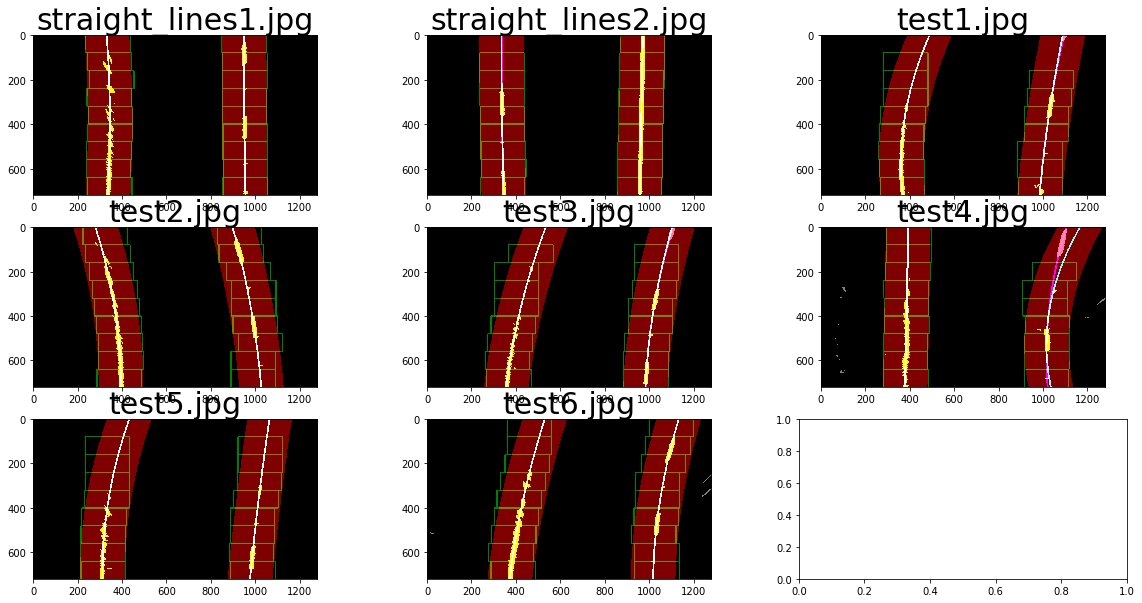

In [15]:
### CELL 14 ###

# Combine both search strategies (proximity + slidewindow) taking into consideration 
# old_lane lane details
def combined_search(old_lane, image):
    # do slidewindow search
    slidewindow_lane, slidewindow_img = slidewindow_search(image)
    out_img = slidewindow_img
    next_lane = None
    if old_lane is not None:
        # if there is an old_lane, do a proximity search around it
        proximity_lane, proximity_img = proximity_search(old_lane, image)
        if proximity_lane is not None:
            # if we found something using proximity search, ...
            # ... we have to create an a aggregated output image
            out_img = np.maximum(slidewindow_img, proximity_img)
            ys = np.linspace(0, image.shape[0]-1, image.shape[0] )
            average_lane = (old_lane + proximity_lane)/2
            proximity_lane_avg = (old_lane + proximity_lane)/2
            proximity_insanity = proximity_lane_avg.insanity(ys)
            if slidewindow_lane is not None:
                # ... & if we also found something using slidewindow search ...
                slidewindow_lane_avg = (old_lane + slidewindow_lane)/2
                slidewindow_insanity = slidewindow_lane_avg.insanity(ys)
                # ... we will decide which search result to pick using the "insanity" metric
                if (proximity_insanity < slidewindow_insanity):
                    next_lane = proximity_lane_avg
                else:
                    next_lane = slidewindow_lane_avg
            else:
                # ... if we found only something using proximity search, use this result
                next_lane = proximity_lane_avg
        else: 
            # if we found nothing using proximity search, use the slidewindow result
            next_lane = slidewindow_lane
    else:
        # if no old_lane is given, we have to take the result of the sliding window search
        next_lane = slidewindow_lane
    return next_lane, out_img

# Testing function (returning the debugging image and discarding the Lane objects)
# as "old_lane" for proximity search, we just use the "current" (slidewindow-found) lane.
def combined_and_plot(image):
    # simple slide window search first to get estimate for polygon
    old_lane, _ = slidewindow_search(image)
    # then do proximity search on same image
    _, out_img = combined_search(old_lane, image)
    return out_img
    
run_all_test_images(combined_and_plot)


### Plot Lane

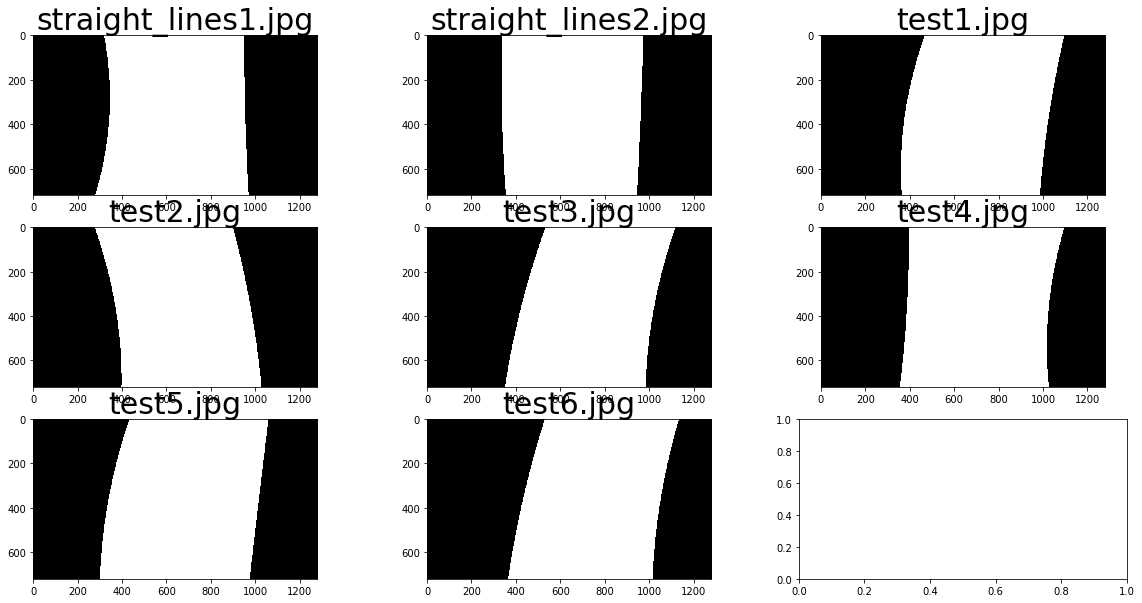

In [16]:
### CELL 15 ###

# Plot a lane onto an (preferably empty) image
def plot_lane(image, lane, laneColor):
    if lane is not None:
        # sample left and right lane line polygon
        fit_ys = np.linspace(0, image.shape[0]-1, image.shape[0] )
        left_fit_xs = lane.left.sample_poly(fit_ys)
        right_fit_xs = lane.right.sample_poly(fit_ys)
        # construct polygon and fill with color
        left_pts = np.array([np.transpose(np.vstack([left_fit_xs, fit_ys]))])
        right_pts = np.array([np.flipud(np.transpose(np.vstack([right_fit_xs, fit_ys])))])
        pts = np.hstack((right_pts, left_pts))
        cv2.fillPoly(image, np.int_(pts), laneColor)
    return image

# Stepping function: for a given new_image & old_lane, calculate a new_lane and a lane line image (lane_img)
def update_lane(old_lane, new_image, laneColor=(1., 1., 1.)):
    new_lane, out_img = combined_search(old_lane, new_image)
    lane_img = np.float_(np.zeros_like(new_image))
    plot_lane(lane_img, new_lane, laneColor)
    return new_lane, lane_img

# Testing function (returning the debugging image and discarding the Lane objects)
# as "old_lane" for proximity search, we just use the "current" (slidewindow-found) lane.
def update_and_plot(image):
    first_lane, _ = slidewindow_search(image)
    _, image = update_lane(first_lane, image)
    return image
    
run_all_test_images(update_and_plot)

## Calculate Curvature, Offset from Center, and Wrap Back to Original

**Task #6:** Calculate the radius of curvature of the lane and the position of the vehicle with respect to center.

Here the idea is to take the measurements of where the lane lines are and estimate how much the road is curving and where the vehicle is located with respect to the center of the lane. The radius of curvature may be given in meters assuming the curve of the road follows a circle. For the position of the vehicle, you may assume the camera is mounted at the center of the car and the deviation of the midpoint of the lane from the center of the image is the offset you're looking for. As with the polynomial fitting, convert from pixels to meters.

**Task #7:** Plot result back down onto the road such that the lane area is identified clearly.

The fit from the rectified image has been warped back onto the original image and plotted to identify the lane boundaries. This should demonstrate that the lane boundaries were correctly identified. An example image with lanes, curvature, and position from center should be included in the writeup (or saved to a folder) and submitted with the project.



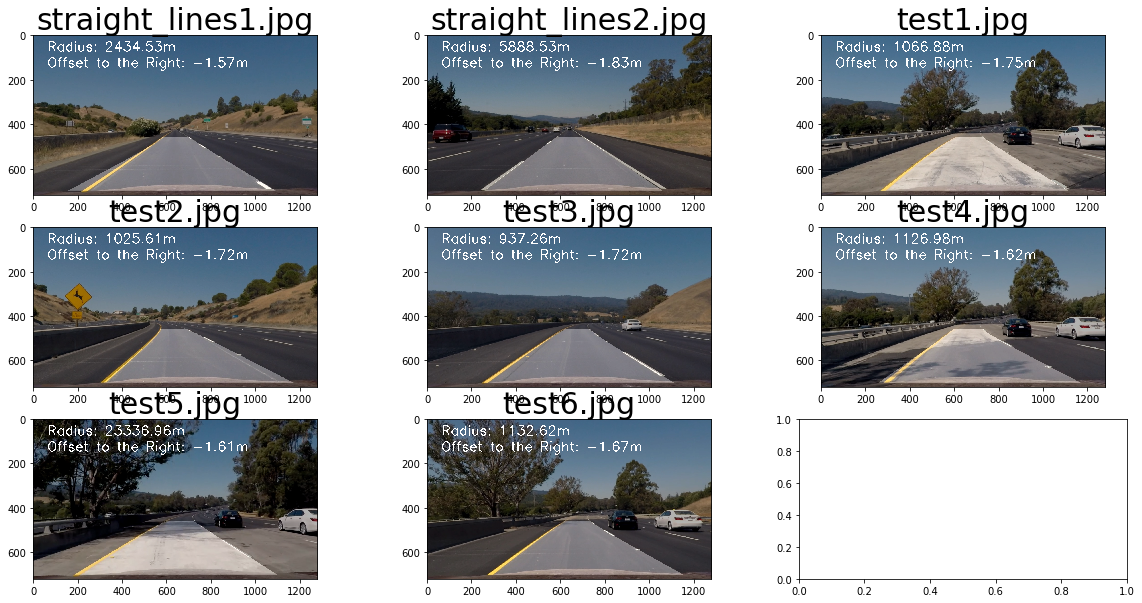

In [17]:
### CELL 16 ###

# Plot Lane metrics onto image
def plot_metrics(image, lane, textColor=(1., 1., 1.)):
    # Plot lane curvature and offset onto image
    if lane is not None:
        height = image.shape[0]
        width = image.shape[1]
        # create texty text
        y = float(height)
        radius = lane.curvature(y)
        offset = lane.offset_from_center(y, image.shape[1]/2.)
        radius_text = "Radius: {:.2f}m".format(radius)
        offset_text = "Offset to the Right: {:.2f}m".format(offset)
        # calculate text dimensions
        radius_y = int(np.ceil(height*.1))
        offset_y = int(np.ceil(height*.2))
        x = int(np.ceil(width*.05))
        size = int(np.ceil(height*.002))
        strength = int(np.ceil(height*.004))
        # put text on image
        cv2.putText(image, radius_text, (x, radius_y), cv2.FONT_HERSHEY_SIMPLEX, size, textColor, strength)
        cv2.putText(image, offset_text, (x, offset_y), cv2.FONT_HERSHEY_SIMPLEX, size, textColor, strength)
    return image

# Stepping function: for a given new_image & old_lane, calculate a new_lane and an output image
# displaying the lane metrics and lane polygon
def update_warp(old_lane, new_image):
    global UNWARP_INV_MATRIX
    dim = (new_image.shape[1], new_image.shape[0])
    # undistort image
    out_image = undistort(new_image)
    # calculate lane and lane-image
    lane, lane_image = update_lane(old_lane, new_image, laneColor=(1., 1., 1.))
    # warp lane-image back onto original image
    warp_lane_image = cv2.warpPerspective(lane_image, UNWARP_INV_MATRIX, dim, flags=cv2.INTER_LINEAR)
    out_image = cv2.addWeighted(out_image/255., 0.7, warp_lane_image, 0.3, 0)
    # write metrics onto image
    plot_metrics(out_image, lane, textColor=(1., 1., 1.))
    return lane, out_image

# Testing function (returning the debugging image and discarding the Lane objects)
# as "old_lane" for proximity search, we just use the "current" (slidewindow-found) lane.
def update_warp_and_plot(image):
    first_lane, _ = slidewindow_search(image)
    _, image = update_warp(first_lane, image)
    return image

run_all_test_images(update_warp_and_plot)

## Process Video

**Task #8:** Provide a link to your final video output. Your pipeline should perform reasonably well on the entire project video (wobbly lines are ok but no catastrophic failures that would cause the car to drive off the road!)

The image processing pipeline that was established to find the lane lines in images successfully processes the video. The output here should be a new video where the lanes are identified in every frame, and outputs are generated regarding the radius of curvature of the lane and vehicle position within the lane. The pipeline should correctly map out curved lines and not fail when shadows or pavement color changes are present. The output video should be linked to in the writeup and/or saved and submitted with the project.

In [18]:
### CELL 17 ###

from moviepy.editor import VideoFileClip
from IPython.display import HTML

# needed to store the old_lane since clip.fl_image(...) only takes 
# functions with one input (= the image)
process_lane_buffer = None

# process a single frame and update process_lane_buffer
def process_frame(image):
    global process_lane_buffer
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    process_lane_buffer, image = update_warp(process_lane_buffer, image)
    # clip.fl_image(...) expects a (0..255) image instead of a (0.0..1.0) image
    return np.int_(image*255)

# process a whole video by processing frame-after-frame
def process_video(video_in, video_out):
    process_lane_buffer = None
    video_in_clip = VideoFileClip(video_in)
    video_out_clip = video_in_clip.fl_image(process_frame)
    video_out_clip.write_videofile(video_out, audio=False)

In [19]:
### CELL 18 ###

# Process the whole video (this takes about 15mins on a MS Azure 8core+GPU Data Science machine!)
process_video("project_video.mp4", "project_video_output.mp4")

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [16:24<00:00,  1.29it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 



In [20]:
### CELL 19 ###

# Output the video
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("project_video_output.mp4"))